In [2]:
!pip install simpy scikit-learn pandas numpy matplotlib


In [3]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [4]:
def queue_simulation(arrival_rate, service_rate, sim_time):
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=1)
    wait_times = []

    def customer(env):
        arrival_time = env.now
        with server.request() as request:
            yield request
            wait_times.append(env.now - arrival_time)
            service_time = random.expovariate(service_rate)
            yield env.timeout(service_time)

    def arrival_process(env):
        while env.now < sim_time:
            yield env.timeout(random.expovariate(arrival_rate))
            env.process(customer(env))

    env.process(arrival_process(env))
    env.run(until=sim_time)

    return np.mean(wait_times) if wait_times else 0


In [5]:
ARRIVAL_RATE_RANGE = (0.5, 5)
SERVICE_RATE_RANGE = (1, 6)
SIM_TIME_RANGE = (50, 200)


In [6]:
data = []

for _ in range(1000):
    arrival_rate = random.uniform(*ARRIVAL_RATE_RANGE)
    service_rate = random.uniform(*SERVICE_RATE_RANGE)
    sim_time = random.uniform(*SIM_TIME_RANGE)

    avg_wait = queue_simulation(arrival_rate, service_rate, sim_time)

    data.append([arrival_rate, service_rate, sim_time, avg_wait])

df = pd.DataFrame(data, columns=[
    "arrival_rate", "service_rate", "simulation_time", "avg_wait_time"
])

df.head()


,arrival_rate,service_rate,simulation_time,avg_wait_time
0,2.738427,2.221401,151.286790,9.232774
1,4.593274,5.531405,93.491777,0.506485
2,2.502785,3.331799,152.125059,0.416161
3,3.738831,3.601096,93.209599,1.230947
4,2.431889,4.812854,76.391651,0.136400


In [7]:
X = df[["arrival_rate", "service_rate", "simulation_time"]]
y = df["avg_wait_time"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [8]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results.append([name, mae, rmse, r2])


In [9]:
results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2 Score"])
results_df.sort_values(by="RMSE")


,Model,MAE,RMSE,R2 Score
3,Random Forest,1.667971,3.255052,0.946546
4,Gradient Boosting,2.042662,3.596467,0.934744
2,Decision Tree,2.248503,4.342902,0.904846
0,Linear Regression,6.698728,8.293798,0.652965
1,Ridge Regression,6.698140,8.294516,0.652904


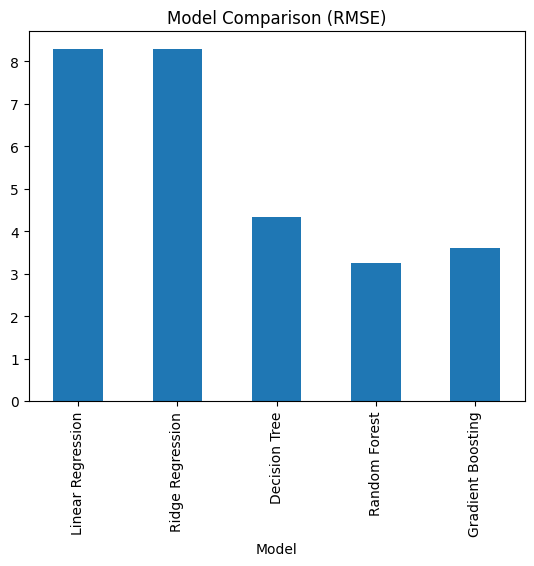

In [10]:
results_df.plot(
    x="Model",
    y="RMSE",
    kind="bar",
    title="Model Comparison (RMSE)",
    legend=False
)
plt.show()
